In [59]:
from google.colab import drive

drive.mount("/content/my_drive/")

Drive already mounted at /content/my_drive/; to attempt to forcibly remount, call drive.mount("/content/my_drive/", force_remount=True).


In [60]:
import os
os.chdir('/content/my_drive/My Drive')

In [61]:
print(os.getcwd())

/content/my_drive/My Drive


In [62]:
#import argparse
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import load_model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
import seaborn as sb

In [63]:
input_path = "/content/my_drive/My Drive/data_action.txt"
print(input_path)

/content/my_drive/My Drive/data_action.txt


In [64]:
data_raw = list()
try:
    with open(input_path, 'r') as f:
        data_raw.append(f.readlines())
except:
    print("can't open file, file not exist")

print(data_raw)

[['0.43617021276595747, 0.03194888178913738, 0.10638297872340426, 0.0, 0.0, 0.2012779552715655, 0.648936170212766, 0.09904153354632587, 0.6595744680851063, 0.038338658146964855, 0.7659574468085106, 0.2364217252396166, 1.0, 0.10223642172523961, 0.22340425531914893, 0.43450479233226835, 0.2127659574468085, 0.731629392971246, 0.10638297872340426, 1.0, 0.6595744680851063, 0.43130990415335463, 0.9893617021276596, 0.6677316293929713, 0.8936170212765957, 1.0, punch\n', '0.36904761904761907, 0.03194888178913738, 0.011904761904761904, 0.0, 0.0, 0.17252396166134185, 0.6309523809523809, 0.07028753993610223, 0.6309523809523809, 0.038338658146964855, 0.75, 0.2364217252396166, 1.0, 0.10223642172523961, 0.14285714285714285, 0.43130990415335463, 0.14285714285714285, 0.731629392971246, 0.011904761904761904, 1.0, 0.6309523809523809, 0.43130990415335463, 1.0, 0.6677316293929713, 0.8928571428571429, 1.0, punch\n', '0.26506024096385544, 0.03194888178913738, 0.012048192771084338, 0.0, 0.0, 0.169329073482428

In [65]:
data_x = list()
label_y = list()
for i in range(len(data_raw[0][:])):
    frame_x = np.array([float(elem) for elem in data_raw[0][i].split(',')[:-1]])
    data_x.append(frame_x)
    frame_label = data_raw[0][i].split(',')[-1].strip('\n')
    label_y.append(frame_label)
data_x = np.array(data_x)
label_y = np.array(label_y)
print(data_x)
print(label_y)

[[0.43617021 0.03194888 0.10638298 ... 0.66773163 0.89361702 1.        ]
 [0.36904762 0.03194888 0.01190476 ... 0.66773163 0.89285714 1.        ]
 [0.26506024 0.03194888 0.01204819 ... 0.66773163 0.89156627 1.        ]
 ...
 [0.60962567 0.0619195  0.39572193 ... 0.7120743  0.72192513 1.        ]
 [0.60752688 0.03194888 0.39247312 ... 0.7028754  0.72043011 1.        ]
 [0.56287425 0.         0.36526946 ... 0.69306931 0.68862275 1.        ]]
[' punch' ' punch' ' punch' ... ' wave' ' wave' ' wave']


In [66]:
class_name = ['punch', 'stand', 'wave']

In [67]:
encoder = LabelEncoder()
encoder_Y = encoder.fit_transform(label_y)
one_hot_Y = np_utils.to_categorical(encoder_Y)
print(label_y[500], ": ", encoder_Y[500])
print(label_y[10], ": ", encoder_Y[10])
print(encoder_Y[10], ": ", one_hot_Y[10])
print(encoder_Y[0], ": ", one_hot_Y[0])

 stand :  1
 punch :  0
0 :  [1. 0. 0.]
0 :  [1. 0. 0.]


In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(data_x, one_hot_Y, test_size=0.1, random_state=42)

In [73]:
X_val, Y_val = X_train[1100:, :], Y_train[1100:, :]
X_train, Y_train = X_train[:1100, :], Y_train[:1100, :]
print(X_val.shape)

(151, 26)


In [74]:
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape = (26,)))
model.add(BatchNormalization())
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               3456      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)               512       
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dense_31 (Dense)             (None, 16)                1040      
_________________________________________________________________
batch_normalization_24 (Batc (None, 16)                64        
_________________________________________________________________
dense_32 (Dense)             (None, 3)                

In [75]:
#callbacks
filepath = 'action-openpose.hdf5'

checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_acc',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max')

callbacks_list = [checkpoint]

In [76]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
His = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_test, Y_test), callbacks=callbacks_list)

Train on 1100 samples, validate on 140 samples
Epoch 1/50
1100/1100 [==============================] - 1s 554us/step - loss: 1.0423 - accuracy: 0.5382 - val_loss: 1.0822 - val_accuracy: 0.5143
Epoch 2/50
1100/1100 [==============================] - 0s 70us/step - loss: 0.5841 - accuracy: 0.7791 - val_loss: 1.0778 - val_accuracy: 0.6000
Epoch 3/50
1100/1100 [==============================] - 0s 70us/step - loss: 0.4364 - accuracy: 0.8709 - val_loss: 1.0580 - val_accuracy: 0.6500
Epoch 4/50
  32/1100 [..............................] - ETA: 0s - loss: 0.4416 - accuracy: 0.9062

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1100/1100 [==============================] - 0s 101us/step - loss: 0.3092 - accuracy: 0.9518 - val_loss: 1.0335 - val_accuracy: 0.6143
Epoch 5/50
1100/1100 [==============================] - 0s 74us/step - loss: 0.2699 - accuracy: 0.9545 - val_loss: 0.9913 - val_accuracy: 0.5571
Epoch 6/50
1100/1100 [==============================] - 0s 73us/step - loss: 0.2088 - accuracy: 0.9855 - val_loss: 0.9352 - val_accuracy: 0.5429
Epoch 7/50
1100/1100 [==============================] - 0s 67us/step - loss: 0.1930 - accuracy: 0.9827 - val_loss: 0.8634 - val_accuracy: 0.5929
Epoch 8/50
1100/1100 [==============================] - 0s 73us/step - loss: 0.1689 - accuracy: 0.9891 - val_loss: 0.7763 - val_accuracy: 0.6786
Epoch 9/50
1100/1100 [==============================] - 0s 68us/step - loss: 0.1579 - accuracy: 0.9909 - val_loss: 0.6767 - val_accuracy: 0.7500
Epoch 10/50
1100/1100 [==============================] - 0s 66us/step - loss: 0.1478 - accuracy: 0.9900 - val_loss: 0.5681 - val_accuracy: 0

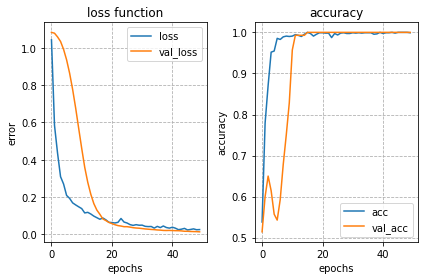

In [78]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("loss function")
ax[0].plot(np.arange(0, 50), His.history['loss'])
ax[0].plot(np.arange(0, 50), His.history["val_loss"])
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("error")
ax[0].grid(linestyle = '--')
ax[0].legend(['loss', 'val_loss'])
ax[1].set_title("accuracy")
ax[1].plot(np.arange(0, 50), His.history['accuracy'])
ax[1].plot(np.arange(0, 50), His.history['val_accuracy'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].grid(linestyle = '--')
ax[1].legend(['acc', 'val_acc'])
plt.tight_layout()
saving_image = plt.savefig('plot.png')

In [79]:
model.save('action-openpose.hdf5')

In [80]:
save_model = load_model('action-openpose.hdf5')

In [81]:
score = save_model.evaluate(X_val, Y_val, verbose = 1)
print(score[0],'\n',score[1])

151/151 [==============================] - 0s 442us/step
0.015206994069431792 
 1.0


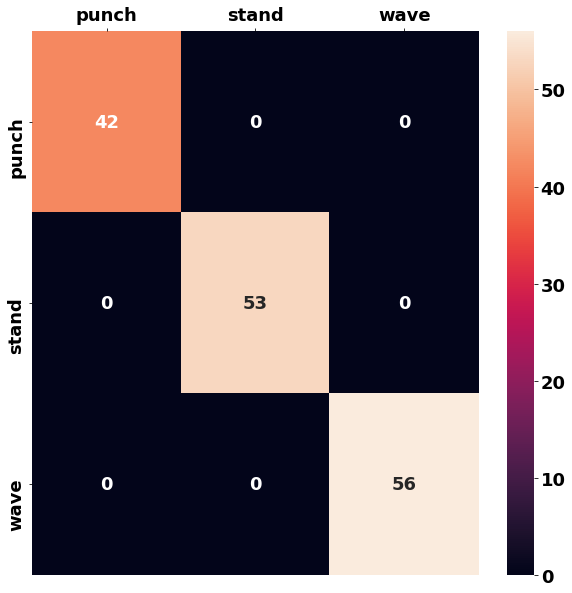

In [89]:
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
plt.rc('font', **font)

pred = save_model.predict(X_val, batch_size = 32)
confusionMatrix = confusion_matrix(np.argmax(Y_val, axis = 1),np.argmax(pred, axis = 1))
df_cm = pd.DataFrame(confusionMatrix, index = [i for i in class_name],
                  columns = [i for i in class_name])

fig, ax = plt.subplots()
ax.xaxis.tick_top()
fig.set_size_inches((10,10))
sb.heatmap(df_cm, annot=True,ax=ax)
plt.savefig('confusion_matrix.png')